# Описание задачи
## В задачи пректа входит:
- Нахождение данных для обученяи модели: парсинг и/или иные источники, обогащение данных;
- Отбор признаков, подбор модели/ансамбля моделей;
- Обучение и тестирование отобранной модели на отобранных признаках, подбор макропараметров;
- Получение предсказанных моделью значений, подготовка и отправка submission


## Этапы работы над проектом:
- Поолучение данных для обученяи модели (на этом этапе без парсинга, при неудоволетворительном результате провести парсинг);
- EDA полученных данных
- Предобработка полученных данных
- Выбор модели и получение baseline
- Создание новых признаков,;
- Отбор признаков;
- Обучение и тестирование выбранной модели на отобранных признаках;
- Подбор макропараметров модели на отобранных признаках;
- Ансамблирование
- Получение предсказанных моделью значений, подготовка и отправка submission

# Импорт библиотек, установка параметров, определение функций
## Импорт бибилиотек

In [1]:
import pandas as pd
import numpy as np
import json 
import os
import requests
import seaborn as sns

from pprint import pprint
from bs4 import BeautifulSoup 

## Установка параметров

In [2]:
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

Populating the interactive namespace from numpy and matplotlib


## Определение функций

In [3]:
def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] 
                 if len(df[col].value_counts())!=0 else np.NAN 
                 for col in  df.columns]
    return desc

def f1(row_name):
    train_index = data.index[data['sample']==1]
    test_index = data.index[data['sample']==0]
    
    plt.figure(figsize=(16,7))

    ax1 = plt.subplot(131)
    sns.countplot(y=data.loc[train_index][row_name],ax = ax1)
    ax1.set_xscale('log')
    ax1.set_title('train')

    ax2 = plt.subplot(132, sharey=ax1)
    sns.countplot(y=data.loc[test_index][row_name],ax = ax2)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.set_xscale('log')
    ax2.set_title('test')

    ax3 = plt.subplot(133, sharey=ax1)
    sns.countplot(y=data[row_name],ax = ax3)
    plt.setp(ax3.get_yticklabels(), visible=False)
    ax3.set_xscale('log')
    ax3.set_title('train & test');

def f_2(row_name):
    plt.figure(figsize=(16,7))

    ax1 = plt.subplot(111)
    sns.boxplot(x=train.price, y=train[row_name],ax = ax1)
    ax1.set_xscale('log')
    ax1.set_title('train')    


def preproc():
    pass

В моем распоряжении есть данные, использованные в *baselin-ах* соревнований 
[[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price)
 и [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction),  
доступные по [здесь](https://www.kaggle.com/itslek/baseline-sf-dst-car-price-prediction-v15/data?select=all_auto_ru_09_09_2020.csv )  
 
На первом этапе будем работать с этими данным, в процессе обработки признаков, сосздания новых, обучения , оотбора признаков, отбора моделей и их композиций получим представление какие дополнительные данные нужны для улучшенияпредсказания (и насколько нужны дополнительные данные, возможно будут получены приемлемые результаты и без них)

Нам так жепредоставлены данные для вычисления *submition*. В первую очередь следует проверить взаимное соответсвие признаков в этих наборах данных, при необходимости/возможности привести данные к единому виду

## Чтение, ознакомление с данными

In [4]:
train = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')
test = pd.read_csv('./Project_5_data/test.csv')

Сеачала сравним признаки, описывающие наблюдения в наборах данных для обучения и для получения предсказания. При необходимости предпримем меры для приедения наборов к одному набору признаков.
Затем посмотрим на простую статистику каждого набора и сопоставим её.

In [5]:
pd.DataFrame({'train_columns':pd.Series(train.columns), 'test_columns':pd.Series(test.columns)}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
train_columns,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
test_columns,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,NaN,NaN,NaN


Как видим вплоть до 21-ой колонки все совпадает,после чего в 22-ой позиции в **train** находится целевая переменная, естественно отсутвующая в **test**, имеющем на этом месте колонку **id**.  
Далее в **data** присутсвуют **start_date**, **hidden**, **model**. В **test** они отсутсвуют.

Посмотрим на простую статистику у обеих DataFrame-ов:
#### train

In [6]:
df_describe(train)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
bodyType,89377,168,Внедорожник 5 дв.,31885.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
brand,89378,36,MERCEDES,8012.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
color,89378,16,040001,25212.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
fuelType,89378,6,бензин,75053.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
modelDate,89377,78,2006,6138.0,2008.54,7.41544,1904,2009,2020,<class 'numpy.float64'>,1
name,89377,4484,2.0 AT (150 л.с.),1610.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
numberOfDoors,89377,5,5,51625.0,4.51047,0.653203,0,5,5,<class 'numpy.float64'>,1
productionDate,89378,80,2020,12524.0,2010.83,7.02478,1904,2011,2020,<class 'numpy.int64'>,0
vehicleConfiguration,89377,1860,SEDAN MECHANICAL 1.6,4166.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
vehicleTransmission,89377,4,AUTOMATIC,49218.0,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1


В пераую очередь надо отметить что в целевой перменной `price` 410 пропусков, наблюдения с пррпусками исключим.
В 9-ти колонках по 1 -му пропуску, возможно это одно "дефектное" наблюдение.

In [7]:
train[train.bodyType.isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
24624,NaN,HONDA,CACECB,универсал,NaN,NaN,NaN,1989,NaN,NaN,NaN,NaN,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",400000,"{'id': '0', 'name': ''}",NaN,LEFT,NaN,3.0,ORIGINAL,True,NaN,120000.0,2020-04-10T16:07:57Z,NaN,CIVIC


Так и есть - отбрасываем наблюдение.
Полностью из пропусков состоят `Состояние` `hidden` 


In [8]:
# удаление отброшенных наблюдений
train.dropna(subset=['price'],inplace=True)
train.dropna(subset=['bodyType'],inplace=True)



#### test

In [9]:
df_describe(test)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
bodyType,3837,11,внедорожник 5 дв.,1626,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
brand,3837,1,BMW,3837,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
color,3837,15,чёрный,1395,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
fuelType,3837,4,бензин,2471,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
modelDate,3837,31,2013,380,2009.95,5.45162,1975,2011,2019,<class 'numpy.float64'>,0
name,3837,384,35i 3.0 AT (306 л.с.) 4WD,193,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
numberOfDoors,3837,4,5,1963,4.37503,0.796782,2,5,5,<class 'numpy.float64'>,0
productionDate,3837,37,2013,432,2011.93,5.18658,1981,2013,2019,<class 'numpy.float64'>,0
vehicleConfiguration,3837,99,ALLROAD_5_DOORS AUTOMATIC 3.0,850,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
vehicleTransmission,3837,3,автоматическая,3677,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0


Как видим в test всего 3837 набдюдений, 







отдельно стоит отметит, что в `brand` одно уникальное значение **BMW**

Видимо имеет смысл разделить train на часть, содержащюю только габлюдения  BMW и все остальное.

In [10]:
train_rem = train.loc[train.brand!='BMW']

train = train.loc[train.brand=='BMW']



Как уже отмечалось, в train есть 3 колонки, отсутствующие  в test
Посмотрим, что находится в этих "дополнительных" колонках.

#### start_date

In [11]:
train.start_date.sample(5)

7190     2020-09-06T19:31:26Z
8623     2020-09-07T07:35:18Z
7461     2020-07-07T20:27:11Z
7288     2020-08-22T11:14:47Z
11367    2020-07-15T10:54:24Z
Name: start_date, dtype: object

Колонка содержит дату создания обьявления о продаже. Признак вообще скорее всего полезный, но в test такая информация отсутвует, поэтому для обучения колонка непригодна.   
Однако возможно она пригодится при отборе наблюдений - обьявления с различным временем создания, возможно имеют отличное распределение цены (например выгодные преддожения бысто уходят и 
цены более старых предлжений в среденм окажуться выше, возможно, наоборот, поеачалу цена выставляется "с запасом" и потом постепенно снижается пока не станет юлиже к реальности).  
Посмотим как обстоят дела на саом деле.

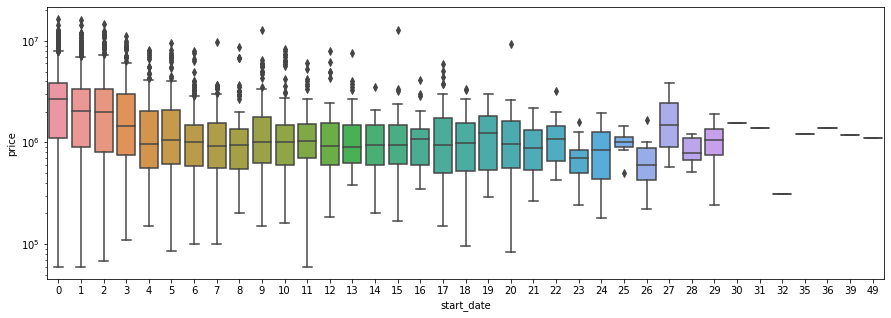

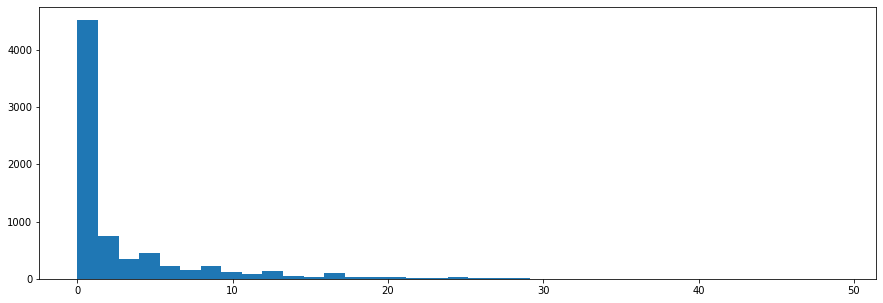

In [12]:
start_date = pd.to_datetime(train.start_date)
recency = (start_date.max()-start_date) // (1*np.timedelta64(1, 'M'))

plt.figure(figsize=(15,5))
plt.yscale("log")
sns.boxplot(x = recency,y = train.price)

plt.figure(figsize=(15,5))
# plt.yscale("log")
# recency.hist(bins = recency.nunique())

plt.hist(recency,bins = recency.nunique());


Видим заметную гетероскедастичность цены по времени создания обьвления. Причины могут быть разными, например более престижные и соответсвенно хоть и подержанные но недешовые авто продаются быстрее. Поэтому посмотим на зависимость цены от от времени создания обьявления для несольких конкретных моделей, а именно для 4-х наиболее популярных моделей. Ограничесмся глубиной в 10 первых месяцев.

(-0.5, 10.5)

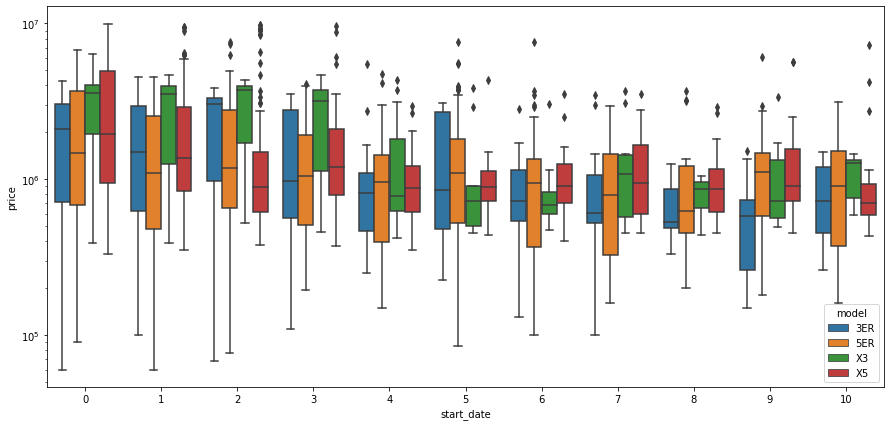

In [13]:
to_consider = train.model.value_counts().index[:4]
consider_mask = [x in to_consider for x in train.model]


plt.figure(figsize=(15,7))
plt.yscale("log")
sns.boxplot(x = recency[consider_mask],y = train[consider_mask].price,hue=train[consider_mask].model)
plt.xlim(xmax=10.5)

(0, 51.45)

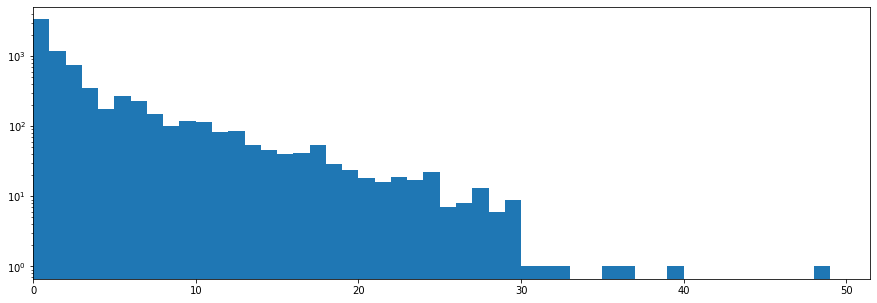

In [14]:
plt.figure(figsize=(15,5))
plt.yscale("log")
# recency.hist(bins = recency.nunique())
# plt.hist(recency,bins = recency.nunique(),cumulative=True);
plt.hist(recency,bins = recency.unique().max());
plt.xlim(xmin=0)

Как видим в течение всего 4-5 месяцев месяцев экспозиции обьявления количество обьявлений падает почти на 2 порядка.  

**  

**  

**  


#### hidden

In [15]:
train.hidden.sample(5)

9312   NaN
5693   NaN
5042   NaN
9979   NaN
7875   NaN
Name: hidden, dtype: float64

In [16]:
train.hidden.notna().sum()

0

Как видим колнка не содержит никакой информации.

#### model

In [17]:
train[['model','name']].sample(15)

,model,name
9425,X3,20d xDrive 2.0d AT (190 л.с.) 4WD
4156,1ER,130i 3.0 AT (265 л.с.)
8686,X1,20d 2.0d AT (184 л.с.) 4WD
9427,X3,20d xDrive 2.0d AT (190 л.с.) 4WD
8538,X1,18i 2.0 AT (150 л.с.)
10887,X6,M50d 3.0d AT (381 л.с.) 4WD
9148,X3,20d xDrive 2.0d AT (190 л.с.) 4WD
6852,5ER,528i 2.8 AT (193 л.с.)
11201,X6,35i 3.0 AT (306 л.с.) 4WD
6096,5ER,530i xDrive 2.0 AT (249 л.с.) 4WD


In [18]:
test.name.sample(5)

3319              30i 3.0 AT (272 л.с.) 4WD
3391      20d xDrive 2.0d AT (190 л.с.) 4WD
2330                 318i 2.0 AT (143 л.с.)
1921    730Ld xDrive 3.0d AT (249 л.с.) 4WD
2334      750i xDrive 4.4 AT (450 л.с.) 4WD
Name: name, dtype: object

#### id

In [19]:
test.id.sample(5)

441      441
805      805
1472    1472
349      349
1060    1060
Name: id, dtype: int64

Похоже, что эта колонка просто дублирует индекс, проверим:

In [20]:
(test.index != test.id).sum()

0

Так и есть, можно удалять.

### price
Посмотрим и на нашу целевую переменную.

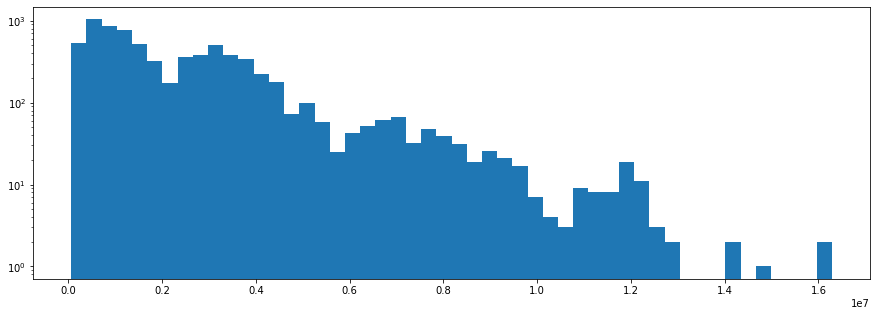

In [21]:
plt.figure(figsize=(15,5))
plt.yscale("log")
# plt.xscale("log")
# plt.hist(x=train.price,bins=50,density=True);
plt.hist(x=train.price,bins=50); #,log=True

Теперь перейдем к пропускам.

Наша целевая переменная `price`, вначале проверим наличие пропусков в ней.

In [22]:
print('В целевой переменной {} пропущенных значений'.format(train.price.isna().sum()))


В целевой переменной 0 пропущенных значений


Теперь изучим совпадающие по названию признаки попарно, рассмотрим так же и несовпадающие признаки.

Ознакомимся с признаками поподробнее

### Для корректной обработки признаков объединяем трейн и тест в один датасет data

In [23]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0   # помечаем где у нас тест
test['price'] = np.NaN  # в тесте нет значения price -  пока просто заполняем np.NaN

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

### Типы признаков
Разделим признаки на количественные num_cols , категориальные cat_cols и бинарные bin_cols. К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.  
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9
Порогом для количественного признака будет наличие более чем 10 уникальных значений.
Разделение признаков на типы позволит провести адекватную EDA и кодировку признаков  .

In [24]:
num_uniq = data.nunique()
# time_col = pd.Inwwwwwwwdex(['app_date'])
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = data.columns[num_uniq>=10]

In [25]:
bin_cols

Index(['Таможня', 'sample'], dtype='object')

In [26]:
cat_cols

Index(['fuelType', 'numberOfDoors', 'vehicleTransmission', 'Привод', 'Руль',
       'Владельцы', 'ПТС'],
      dtype='object')

In [27]:
num_cols

Index(['bodyType', 'color', 'modelDate', 'name', 'productionDate',
       'vehicleConfiguration', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Владение', 'id', 'price',
       'start_date', 'model'],
      dtype='object')

In [28]:
data.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id', 'sample', 'price',
       'start_date', 'hidden', 'model'],
      dtype='object')

Перед предобработкой признаков создадим копию датафрейма.

In [29]:
# train = df.copy()
pd.co

In [62]:
def df(data):
    import re
    df = data.copy()
    
    # bodyType
    df.bodyType = df.bodyType.dropna().apply(lambda x: x.split()[0]).str.lower()
    df.bodyType = pd.get_dummies(df.bodyType)
    
    # brand
    df.drop(column = ['brand'],inplace=True)
    
    # color
    color_codes = {
    '040001': 'чёрный',
    'FAFBFB': 'белый', 
    '0000CC': 'синий', 
    '200204': 'коричневый', 
    'EE1D19': 'красный', 
    'CACECB': 'серый',
    'C49648': 'бежевый', 
    '97948F': 'серебристый', 
    'FFD600': 'золотистый', 
    'FF8649': 'оранжевый', 
    '22A0F8': 'голубой',
    'FFC0CB': 'пурпурный', 
    'DEA522': 'жёлтый', 
    '007F00': 'зелёный', 
    '660099': 'фиолетовый',
    '4A2197': 'фиолетовый'}
    df.color = df.color.map(color_codes)
    df.color = pd.get_dummies(df.color)
    
    # fuelType
    to_drop = df.index[df.fuelType=='универсал']
    df.drop(index=to_drop,inplace=True)
    df.fuelType = pd.get_dummies(df.fuelType)
    
    # modelDate
    df.modelDate = df.modelDate.dropna().astype(int)
    
    # name
    df.name = df.name.apply(lambda x: x[:x.find(' ')])
    df.name = pd.get_dummies(df.name)
    
    # numberOfDoors
    df.numberOfDoors = df.numberOfDoors.astype(int)
    df.numberOfDoors = pd.get_dummies(df.numberOfDoors)
    
    # productionDate
    data.productionDate = data.productionDate.astype(int)

    
    # vehicleConfiguration
    df.vehicleConfiguration = df.vehicleConfiguration.str.split().apply(lambda x:x[0])
    df.vehicleConfiguration = pd.get_dummies(df.vehicleConfiguration)
    
    # vehicleTransmission
    transmission_dict = {
    'автоматическая':'автоматическая',
    'механическая':'механическая',
    'роботизированная':'роботизированная',
    'MECHANICAL':'механическая', 
    'AUTOMATIC':'автоматическая', 
    'ROBOT':'роботизированная', 
    'VARIATOR':'автоматическая'}
    df.vehicleTransmission = df.vehicleTransmission.map(transmission_dict)
    df.vehicleTransmission = pd.get_dummies(df.vehicleTransmission)
    
    # engineDisplacement
    df.engineDisplacement = df.engineDisplacement.apply(lambda x: x.split()[0])
    
    # enginePower
    df.enginePower = df.enginePower.str[:-4].astype(int)
    
    # description
    df.description = df.description.str.len()
    
    # mileage
    df.mileage = df.mileage 
    
    # Комплектация
    
    
    # Привод
    df_test.Привод = pd.get_dummies(df_test.Привод)
    
    # Руль
    df.drop(column = ['Руль'],inplace=True)
    
    # Состояние
    df.drop(column = ['Состояние'],inplace=True)
    
    # Владельцы
    df.Владельцы = df.Владельцы.fillna(0).apply(lambda x: int(x[0]) if type(x) == str else int(x))
    df.Владельцы = pd.get_dummies(df_test.Владельцы)
    
    # ПТС
    owner_dict = {
    'Оригинал':'Оригинал',
    'Дубликат':'Дубликат',
    'ORIGINAL':'Оригинал',
    'DUPLICATE':'Дубликат'}

    df.ПТС = df.ПТС.fillna('Оригинал').map(owner_dict)
    
    # Таможня
    df.drop(column = ['Таможня'],inplace=True)
    
    # Владение
    df['ownrshp_know'] = data.Владение.notna().astype(int)
    pattern_yaer = re.compile('\d+(?= (?:год|лет))')
    pattern_month = re.compile('\d+(?= мес)')
    year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
    month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0
    data.Владение.apply(lambda x: year(x)*12 + month(x) if x==x else x).fillna(-999.)
    
    
    

## Изучение признаков
Теперь изучим признаки по отдельности
.
.
.

### bodyType
Посмотрим как выгдядит значения в колонке:

In [74]:
data.bodyType.sample(5)

5832                 Седан
5884                 Седан
6917                 Седан
0                    седан
10907    Внедорожник 5 дв.
Name: bodyType, dtype: object

В колонке содержится категоря кузова/авто (седан, хэтчбэк, внедорожник и т.д.) и опционно количество дверей. Поскольку в наборе данных есть колонка `numberOfDoors`, то можно огброситть информацию о количестве дверей из  этой колонки. Извлечем только категорию авто.

In [30]:
data.bodyType = data.bodyType.dropna().apply(lambda x: x.split()[0]).str.lower()
train.bodyType = train.bodyType.dropna().apply(lambda x: x.split()[0]).str.lower()
test.bodyType = test.bodyType.dropna().apply(lambda x: x.split()[0]).str.lower()


pd.get_dummies(data.bodyType)

,внедорожник,кабриолет,компактвэн,купе,купе-хардтоп,лифтбек,родстер,седан,универсал,хэтчбек
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11197,0,0,0,0,0,0,1,0,0,0
11198,0,0,0,0,0,0,1,0,0,0
11199,0,0,0,0,0,0,1,0,0,0
11200,0,0,0,1,0,0,0,0,0,0


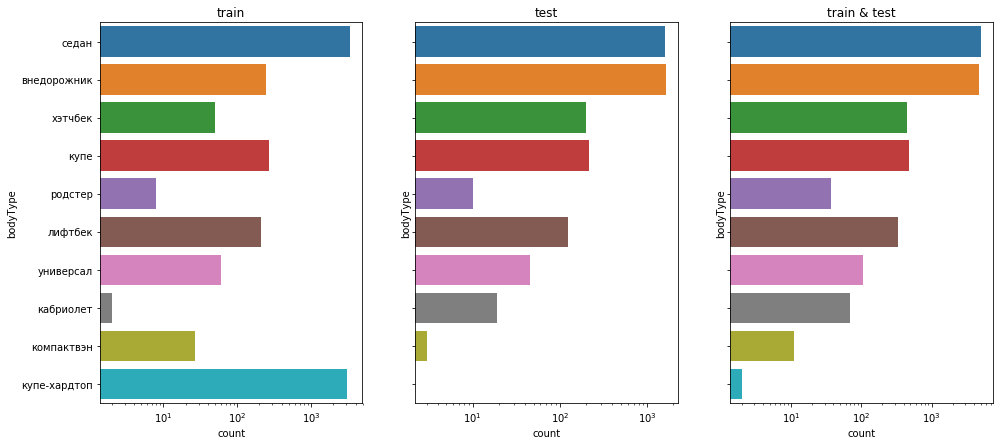

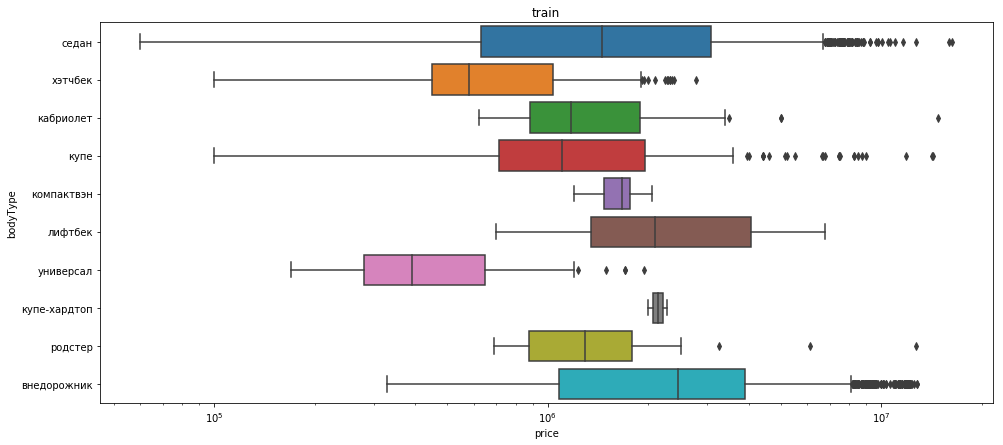

In [76]:
f1('bodyType')
f_2('bodyType')

### brand

In [77]:
test.brand.unique()

array(['BMW'], dtype=object)

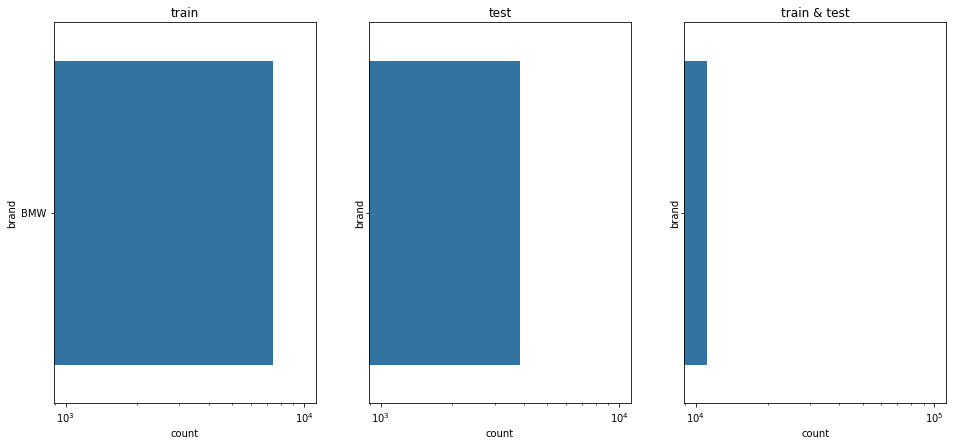

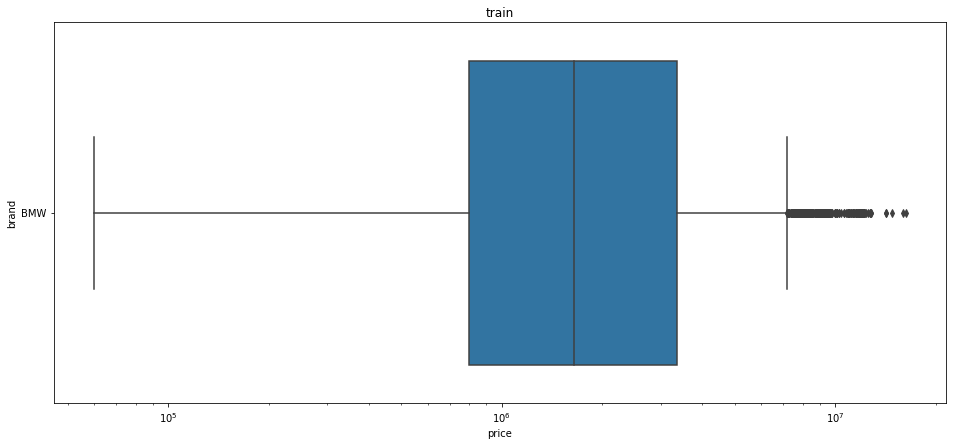

In [78]:
f1('brand')
f_2('brand')

### color

In [79]:
color_codes = {
    '040001': 'чёрный',
    'FAFBFB': 'белый', 
    '0000CC': 'синий', 
    '200204': 'коричневый', 
    'EE1D19': 'красный', 
    'CACECB': 'серый',
    'C49648': 'бежевый', 
    '97948F': 'серебристый', 
    'FFD600': 'золотистый', 
    'FF8649': 'оранжевый', 
    '22A0F8': 'голубой',
    'FFC0CB': 'пурпурный', 
    'DEA522': 'жёлтый', 
    '007F00': 'зелёный', 
    '660099': 'фиолетовый',
    '4A2197': 'фиолетовый'}

In [80]:
train.color.unique()

array(['FF8649', 'FAFBFB', 'EE1D19', '040001', '0000CC', '97948F',
       '22A0F8', 'CACECB', '200204', '660099', 'C49648', 'FFD600',
       '007F00', '4A2197', 'DEA522', 'FFC0CB'], dtype=object)

In [81]:
test.color.unique()

array(['чёрный', 'белый', 'синий', 'коричневый', 'красный', 'серый',
       'бежевый', 'серебристый', 'золотистый', 'оранжевый', 'голубой',
       'пурпурный', 'жёлтый', 'зелёный', 'фиолетовый'], dtype=object)

In [82]:
data.color = data.color.map(color_codes)

In [86]:
pd.get_dummies(data.color)[:5]

,бежевый,белый,голубой,жёлтый,зелёный,золотистый,коричневый,красный,оранжевый,пурпурный,серебристый,серый,синий,фиолетовый,чёрный
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


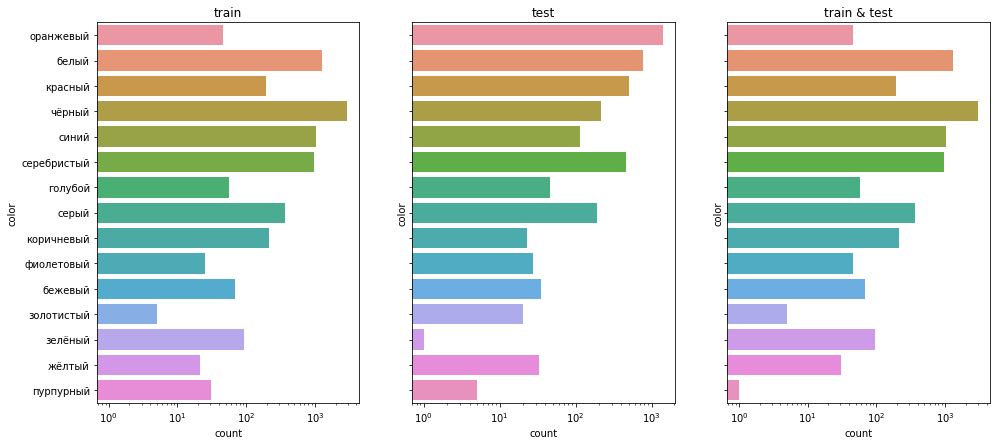

In [87]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(131)
sns.countplot(y=train.color,ax = ax1)
ax1.set_xscale('log')
ax1.set_title('train')

ax2 = plt.subplot(132, sharey=ax1)
sns.countplot(y=test.color,ax = ax2)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xscale('log')
ax2.set_title('test')

ax3 = plt.subplot(133, sharey=ax1)
sns.countplot(y=data.color,ax = ax3)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_xscale('log')
ax3.set_title('train & test');

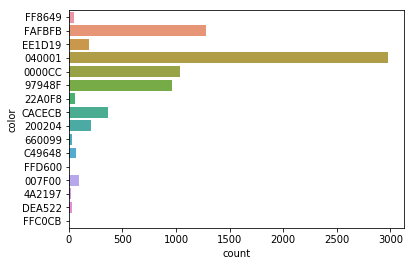

In [88]:
ttt = train.color.dropna()

fig = plt.figure()
# ax = fig.add_axes([0, 0, 1, 1])
# ax.set_xscale( 'log' )
sns.countplot(y=ttt)

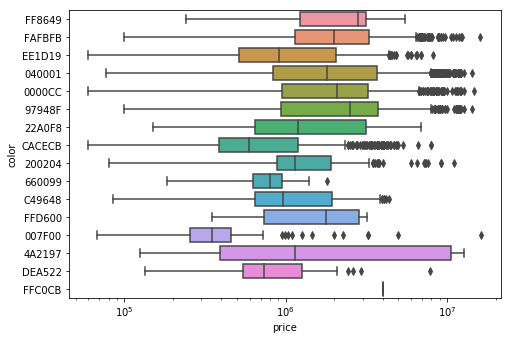

In [89]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = train.price, y=ttt)

### fuelType

In [34]:
data.fuelType.unique()

array(['дизель', 'бензин', 'гибрид', 'электро'], dtype=object)

Очевидно, что категория 'универсал' - это ошибка.

In [35]:
to_drop = data.index[data.fuelType=='универсал']
data.drop(index=to_drop,inplace=True)

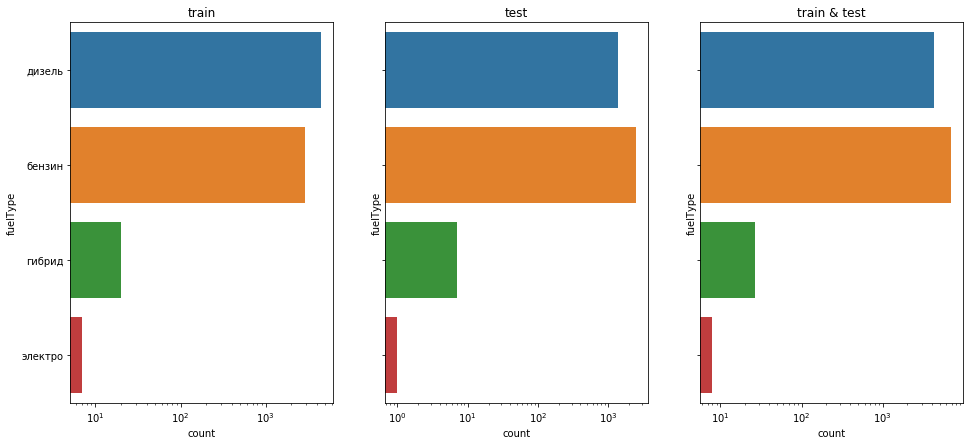

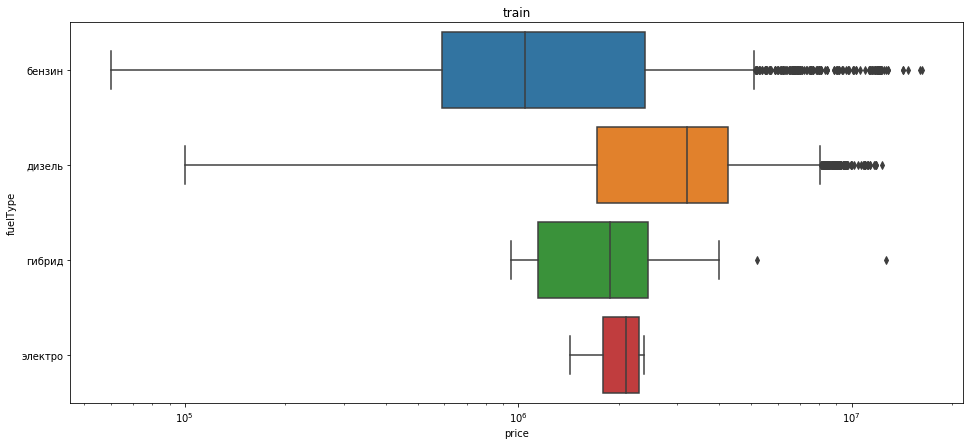

In [38]:
f1('fuelType')
f_2('fuelType')

In [39]:
pd.get_dummies(data.fuelType)[:5]

,бензин,гибрид,дизель,электро
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0


### modelDate

In [41]:
data.modelDate.dropna().unique()

array([2016., 2018., 2009., 2014., 2013., 2010., 2006., 2011., 2007.,
       2005., 2008., 2000., 2012., 2015., 2017., 2002., 2001., 1999.,
       2003., 1998., 2019., 1990., 1995., 2004., 1987., 1981., 1994.,
       1986., 1982., 1975., 1977., 1966., 1937., 1936., 1949., 2020.,
       1976., 1972., 1989., 1968., 1988., 1997.])

In [45]:
data.modelDate.dropna().astype(int)[:5]

0    2016
1    2018
2    2009
3    2014
4    2014
Name: modelDate, dtype: int32

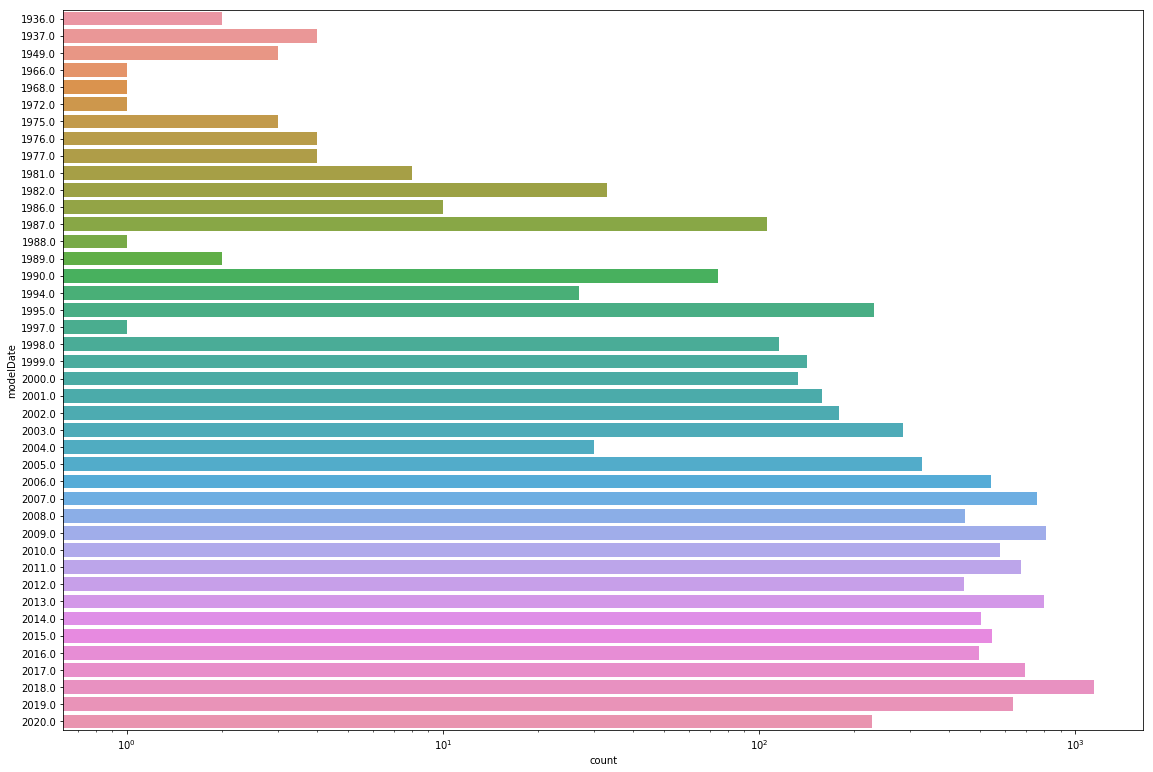

In [44]:
ttt = data.modelDate.dropna()

fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.countplot(y=ttt)

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


KeyboardInterrupt: 

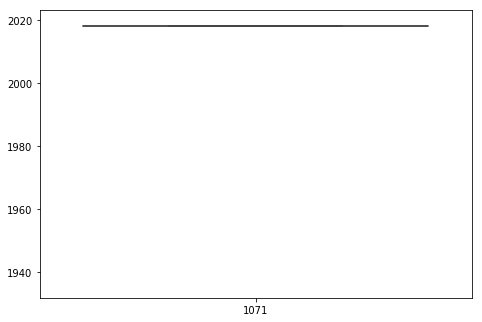

In [47]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = data.price, y=ttt);

### name

In [49]:
train.name.sample(5)

4488                  320i 2.0 AT (184 л.с.)
11237                  4.4 AT (555 л.с.) 4WD
4853      320d xDrive 2.0d AT (184 л.с.) 4WD
8160     730Ld xDrive 3.0d AT (249 л.с.) 4WD
8006                 750Li 4.4 AT (407 л.с.)
Name: name, dtype: object

In [51]:
data.name.loc[0]

'520d 2.0d AT (190 л.с.)'

In [52]:
test.name.apply(lambda x: x[:x.find(' ')])[:5]

0    520d
1    318d
2    550i
3     30d
4    M50d
Name: name, dtype: object

In [53]:
test.name.apply(lambda x: x[:x.find(' ')]).unique()

array(['520d', '318d', '550i', '30d', 'M50d', '28i', '20d', '520i',
       '328i', '116i', '730d', '320i', '335i', '25i', '316i', '3.0d',
       '540i', '730Ld', '35d', '20i', '530d', '528i', '35i', 'xDrive20d',
       '48i', '135i', '2.2', '335xi', '745i', '320d', '530xi', '530i',
       '3.0i', '325i', '30i', '118i', '40i', 'M760Li', '3.0si', '4.4',
       '40d', '4.8i', '535d', '420i', '525i', '750i', '120i', '330i',
       '120d', '318i', '725Ld', '760Li', '840d', '420d', 'M850i', '523i',
       '18d', '650i', '18i', '525d', '750Li', '4.4i', '630d', '645i',
       '3.0', '25d', '535i', '640i', '330xd', 'xDrive20i', '525xi', '50i',
       '740Li', 'M550d', '630i', '4.0', '520Li', '735i', '730Li', '740d',
       '325xi', '518', 'M235i', '220i', '740i', 'Competition', 'M50i',
       '428i', '1.5', '750Ld', 'M40d', '730i', '1.5hyb', '528Li', '640d',
       '3.0sd', 'Electro', '530Li', '740Ld', 'CS', '525xd', 'M40i',
       '330xi', 'M340i', 'M550i', '750d', '35is', '760i', '125i', '130

In [54]:
test.name.sort_values().unique()[:10]

array(['1.5 AT (136 л.с.)', '1.5hyb AT (231 л.с.) 4WD',
       '116i 1.6 AT (115 л.с.)', '116i 1.6 AT (136 л.с.)',
       '116i 1.6 MT (115 л.с.)', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       '118i 1.5 AT (136 л.с.)', '118i 1.6 AT (136 л.с.)'], dtype=object)

In [55]:
# pwr = lambda x: x[x.find('(')+1:x.find(')')]
# ltr = lambda x: x[:x.find(' ')]
# test.name.apply(ltr)
test.loc[5][['name','fuelType','engineDisplacement','vehicleTransmission','enginePower','Привод']]

name                   30d 3.0d AT (249 л.с.) 4WD
fuelType                                   дизель
engineDisplacement                        3.0 LTR
vehicleTransmission                автоматическая
enginePower                               249 N12
Привод                                     полный
Name: 5, dtype: object

### numberOfDoors

In [ ]:
fuelType

In [19]:
print(df_test.numberOfDoors.unique())
df_test.numberOfDoors.astype(int)[:5]

[4. 5. 3. 2.]


0    4
1    4
2    4
3    5
4    5
Name: numberOfDoors, dtype: int32

### productionDate

In [45]:
test.productionDate = test.productionDate.astype(int)
train.productionDate = train.productionDate.astype(int)
data.productionDate = data.productionDate.astype(int)

In [46]:
train.productionDate.unique()

array([1991, 1986, 1989, 1993, 1992, 1994, 1987, 1988, 1985, 1983, 1980,
       1984, 1990, 1981, 1995, 1938, 2014, 2011, 2013, 2012, 2016, 2015,
       2010, 2002, 2000, 2001, 2020, 2008, 2018, 2019, 2007, 2003, 2017,
       2006, 2005, 2004, 2009, 1997, 1999, 1998, 1996, 1982, 1972, 1978,
       1937, 1949, 1948, 1950, 1953, 1975, 1969, 1959, 1974, 1961, 1955,
       1976, 1964, 1971, 1967, 1957, 1931, 1927, 1923, 1924, 1979, 1970,
       1932, 1939, 1977, 1951, 1973, 1954, 1960, 1968, 1904, 1966, 1965,
       1963, 1936, 1952], dtype=int64)

In [47]:
test.productionDate.unique()

array([2017, 2019, 2012, 2015, 2013, 2008, 2011, 2016, 2007, 2014, 2000,
       2009, 2018, 2005, 2003, 2006, 2010, 2002, 2004, 2001, 1997, 1998,
       1999, 1995, 1996, 1993, 1987, 1984, 1989, 1991, 1988, 1994, 1992,
       1981, 1990, 1986, 1982], dtype=int64)

In [48]:
data.productionDate.unique()

array([2017, 2019, 2012, 2015, 2013, 2008, 2011, 2016, 2007, 2014, 2000,
       2009, 2018, 2005, 2003, 2006, 2010, 2002, 2004, 2001, 1997, 1998,
       1999, 1995, 1996, 1993, 1987, 1984, 1989, 1991, 1988, 1994, 1992,
       1981, 1990, 1986, 1982, 1985, 1983, 1980, 1938, 2020, 1972, 1978,
       1937, 1949, 1948, 1950, 1953, 1975, 1969, 1959, 1974, 1961, 1955,
       1976, 1964, 1971, 1967, 1957, 1931, 1927, 1923, 1924, 1979, 1970,
       1932, 1939, 1977, 1951, 1973, 1954, 1960, 1968, 1904, 1966, 1965,
       1963, 1936, 1952], dtype=int64)

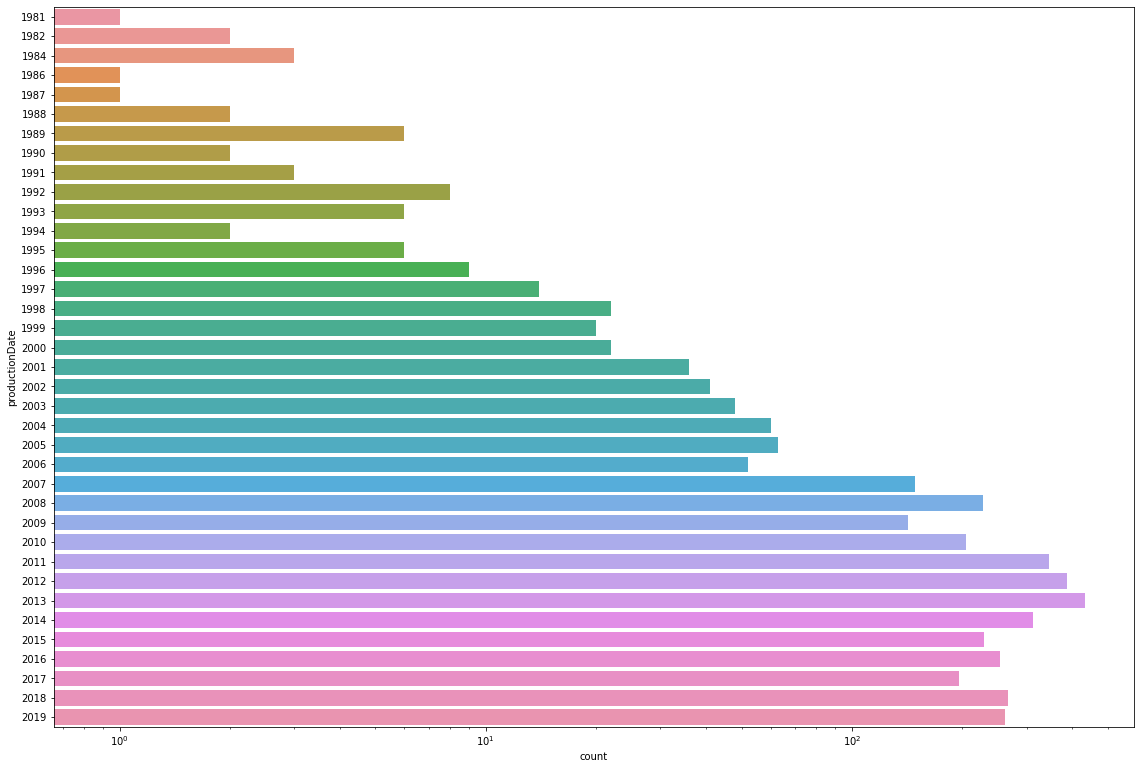

In [50]:
def f_3(row_name):
    ttt = test[row_name].astype(int)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xscale( 'log' )
    sns.countplot(y=ttt) 
    
f_3('productionDate')

### vehicleConfiguration

In [39]:
# df_test.vehicleConfiguration.sort_values().unique()
df_test.vehicleConfiguration.unique()[:10]

array(['SEDAN AUTOMATIC 2.0', 'SEDAN AUTOMATIC 4.4',
       'ALLROAD_5_DOORS AUTOMATIC 3.0', 'ALLROAD_5_DOORS AUTOMATIC 2.0',
       'HATCHBACK_3_DOORS AUTOMATIC 1.6', 'SEDAN AUTOMATIC 3.0',
       'ALLROAD_5_DOORS AUTOMATIC 2.5', 'SEDAN AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.6',
       'ALLROAD_5_DOORS AUTOMATIC 4.8'], dtype=object)

In [25]:
df_test.vehicleConfiguration[:5]

0              SEDAN AUTOMATIC 2.0
1              SEDAN AUTOMATIC 2.0
2              SEDAN AUTOMATIC 4.4
3    ALLROAD_5_DOORS AUTOMATIC 3.0
4    ALLROAD_5_DOORS AUTOMATIC 3.0
Name: vehicleConfiguration, dtype: object

In [32]:
df_test.vehicleConfiguration.str.split().head()

0              [SEDAN, AUTOMATIC, 2.0]
1              [SEDAN, AUTOMATIC, 2.0]
2              [SEDAN, AUTOMATIC, 4.4]
3    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
4    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
Name: vehicleConfiguration, dtype: object

In [29]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[0]).unique()

array(['SEDAN', 'ALLROAD_5_DOORS', 'HATCHBACK_3_DOORS',
       'HATCHBACK_5_DOORS', 'COUPE', 'ROADSTER', 'LIFTBACK',
       'WAGON_5_DOORS', 'CABRIO', 'SEDAN_2_DOORS', 'COMPACTVAN'],
      dtype=object)

In [30]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[1]).unique()

array(['AUTOMATIC', 'MECHANICAL', 'ROBOT'], dtype=object)

In [40]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN).unique()

array(['2.0', '4.4', '3.0', '1.6', '2.5', '4.8', '2.2', '6.6', '1.5',
       '6.0', '1.8', '3.5', '2.8', '4.0', '3.6', '5.4', '2.9', nan, '1.9',
       '5.0', '4.6', '3.4'], dtype=object)

### vehicleTransmission

In [23]:
test.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'роботизированная'], dtype=object)

In [33]:
train.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan], dtype=object)

In [37]:
transmission_dict = {
    'автоматическая':'автоматическая',
    'механическая':'механическая',
    'роботизированная':'роботизированная',
    'MECHANICAL':'механическая', 
    'AUTOMATIC':'автоматическая', 
    'ROBOT':'роботизированная', 
    'VARIATOR':'автоматическая'}

test.vehicleTransmission.map(transmission_dict).unique()

array(['автоматическая', 'механическая', 'роботизированная'], dtype=object)

In [40]:
data.vehicleTransmission = data.vehicleTransmission.map(transmission_dict)
data.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'роботизированная', nan],
      dtype=object)

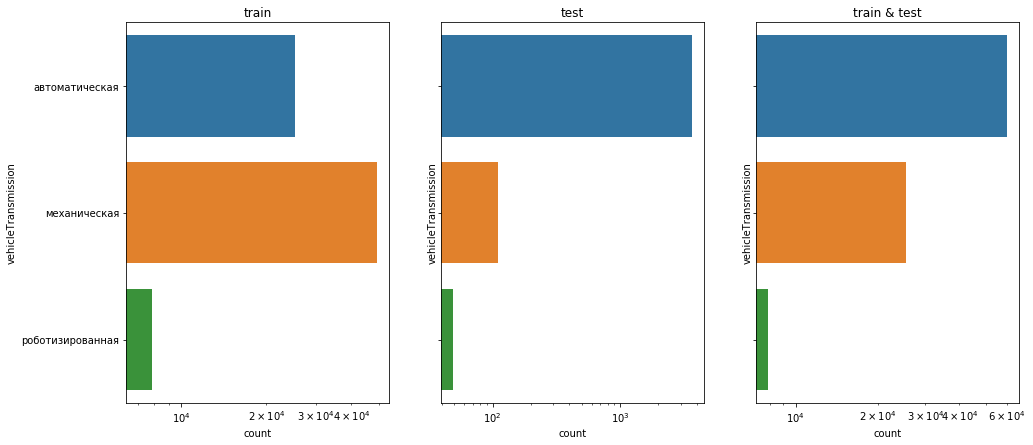

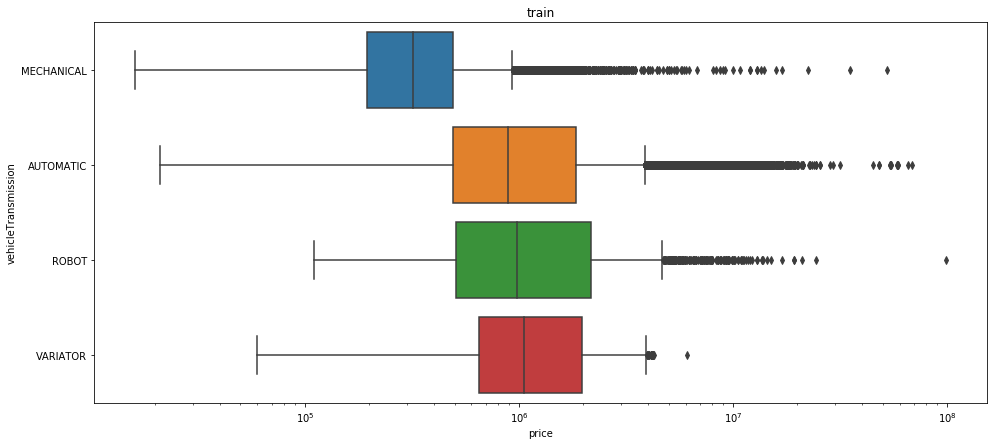

In [42]:
f1('vehicleTransmission')
f_2('vehicleTransmission')

## 

### engineDisplacement

In [24]:
df_test.engineDisplacement.sort_values().unique(), #df.engineDisplacement.sort_values().unique()

(array(['1.5 LTR', '1.6 LTR', '1.8 LTR', '1.9 LTR', '2.0 LTR', '2.2 LTR',
        '2.5 LTR', '2.8 LTR', '2.9 LTR', '3.0 LTR', '3.4 LTR', '3.5 LTR',
        '3.6 LTR', '4.0 LTR', '4.4 LTR', '4.6 LTR', '4.8 LTR', '5.0 LTR',
        '5.4 LTR', '6.0 LTR', '6.6 LTR', 'undefined LTR'], dtype=object),)

In [45]:
df_test.engineDisplacement.apply(lambda x: x.split()[0])[:10]

0    2.0
1    2.0
2    4.4
3    3.0
4    3.0
5    3.0
6    2.0
7    2.0
8    3.0
9    2.0
Name: engineDisplacement, dtype: object

In [52]:
mask = (df_test.engineDisplacement.apply(lambda x: x.split()[0])!=
 df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN))
df_test[mask][['engineDisplacement','vehicleConfiguration']]

,engineDisplacement,vehicleConfiguration
823,undefined LTR,HATCHBACK_5_DOORS AUTOMATIC


### enginePower

In [25]:
df_test.enginePower.sort_values().unique()
df_test.enginePower.str[:-4].astype(int).sort_values().unique()

array([ 90, 100, 102, 105, 113, 115, 118, 122, 125, 129, 136, 140, 143,
       150, 156, 163, 170, 177, 184, 188, 190, 192, 193, 197, 204, 211,
       218, 230, 231, 235, 243, 245, 249, 252, 258, 264, 265, 269, 272,
       286, 300, 306, 313, 320, 326, 329, 333, 340, 347, 355, 360, 367,
       370, 374, 381, 400, 407, 410, 420, 431, 445, 449, 450, 460, 462,
       507, 530, 544, 555, 560, 575, 600, 609, 610, 625], dtype=int64)

In [26]:
# df.enginePower.sort_values().unique()

### description

In [10]:
df.description.str.len()[:5]

0     228.0
1     132.0
2    1147.0
3       NaN
4     204.0
Name: description, dtype: float64

### mileage

In [36]:
data.mileage

0        158836.0
1            10.0
2        120000.0
3        111466.0
4         11891.0
           ...   
11197     40000.0
11198     87000.0
11199    179953.0
11200    105000.0
11201     57000.0
Name: mileage, Length: 11202, dtype: float64

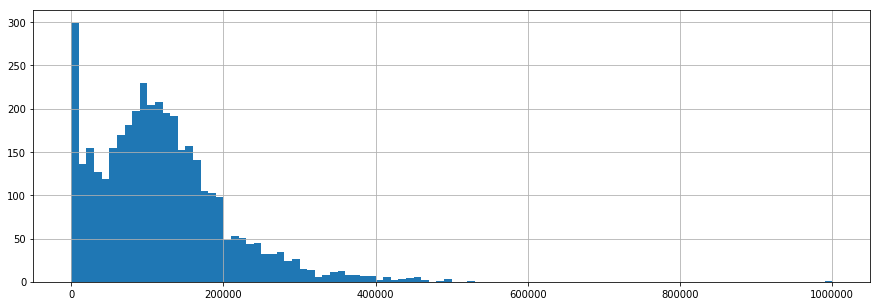

In [60]:
df_test.mileage.nunique()
df_test.mileage.hist(figsize=(15,5),bins=100)

### Комплектация

In [61]:
df_test.Комплектация.nunique()

3295

### Привод

In [63]:
df_test.Привод.unique() #, df.Привод.unique()

array(['задний', 'полный', 'передний'], dtype=object)

### Руль

In [64]:
df_test.Руль.unique() #, df_test.Руль.unique()

array(['Левый'], dtype=object)

### Состояние

In [65]:
df_test.Состояние.unique() #, df.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

### Владельцы

In [39]:
data.Владельцы.unique() #, df.Владельцы.unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более', 1.0, 2.0, 3.0,
       nan], dtype=object)

In [55]:
data.Владельцы.fillna(0).apply(lambda x: int(x[0]) if type(x) == str else int(x))

0        1
1        1
2        2
3        2
4        1
        ..
11197    3
11198    3
11199    3
11200    3
11201    3
Name: Владельцы, Length: 11202, dtype: int64

In [52]:
type(x) == str

True

In [53]:
x = '1\xa0владелец'
# x = 1.0
int(x[0])

1.0

### ПТС

In [67]:
df_test.ПТС.unique() #, df.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

### Таможня

In [68]:
df_test.Таможня.unique()#,df_test.Таможня.unique()

array(['Растаможен'], dtype=object)

### Владение

In [70]:
df_test.Владение.sort_values().unique()[:10]

array(['1 год', '1 год и 1 месяц', '1 год и 10 месяцев',
       '1 год и 11 месяцев', '1 год и 2 месяца', '1 год и 3 месяца',
       '1 год и 4 месяца', '1 год и 5 месяцев', '1 год и 6 месяцев',
       '1 год и 7 месяцев'], dtype=object)

In [71]:
# df.Владение.sort_values().unique()[:10]

In [72]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0

df_test.Владение.apply(lambda x: year(x)*12 + month(x) if x==x else x)[:10]

0     NaN
1     NaN
2    86.0
3     NaN
4     NaN
5     NaN
6    35.0
7     NaN
8    84.0
9     NaN
Name: Владение, dtype: float64

### price

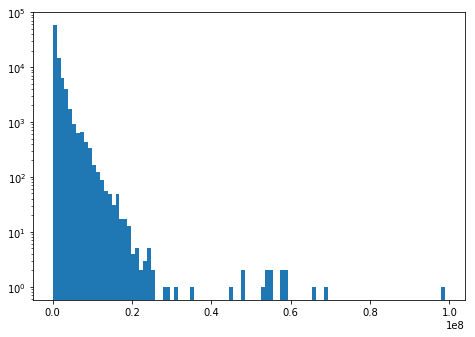

In [49]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_yscale('log')
ax.hist(df.price.dropna(),bins=100);

### start_date

In [69]:
ttt = pd.to_datetime(df.start_date,format='%Y-%m-%d')

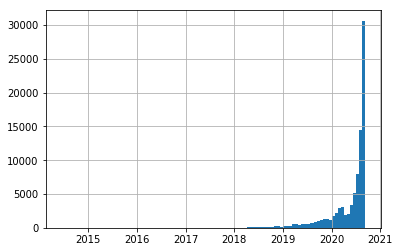

In [72]:
ttt.hist(bins=100)

### id

In [34]:
print(df_test.id.unique())
try: 
    print(df.id.unique())
except:  
    pass

[   0    1    2 ... 3834 3835 3836]


## ===============================================================

## df_test.Комплектация


In [35]:
df_test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [36]:
new_configuration = df_test.Комплектация.apply(lambda x: json.loads(x[2:-2]) if x != '[]' else [])
new_configuration.head()

0    [{'name': 'Безопасность', 'values': ['Антипроб...
1    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
2    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
3    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
4    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
Name: Комплектация, dtype: object

In [37]:
# lambda configuration: [category['name'] for category in configuration]
all_categories = set(new_configuration.apply(lambda configuration: [category['name'] for category in configuration]).sum())
all_categories

{'Безопасность',
 'Защита от угона',
 'Комфорт',
 'Мультимедиа',
 'Обзор',
 'Прочее',
 'Салон',
 'Элементы экстерьера'}

In [38]:
new_configuration[0]

[{'name': 'Безопасность',
  'values': ['Антипробуксовочная система (ASR)',
   'Система стабилизации (ESP)',
   'Подушка безопасности водителя',
   'Крепление детского кресла (задний ряд) ISOFIX',
   'Подушки безопасности оконные (шторки)',
   'Подушка безопасности пассажира',
   'Подушки безопасности боковые задние',
   'Подушки безопасности боковые',
   'Датчик давления в шинах',
   'Антиблокировочная система (ABS)',
   'Блокировка замков задних дверей',
   'Подушка безопасности для защиты коленей водителя']},
 {'name': 'Комфорт',
  'values': ['Система «старт-стоп»',
   'Электростеклоподъёмники передние',
   'Мультифункциональное рулевое колесо',
   'Прикуриватель и пепельница',
   'Бортовой компьютер',
   'Усилитель руля',
   'Электропривод зеркал',
   'Электростеклоподъёмники задние',
   'Парктроник передний',
   'Регулировка руля по вылету',
   'Климат-контроль 2-зонный',
   'Электроскладывание зеркал',
   'Парктроник задний']},
 {'name': 'Мультимедиа',
  'values': ['AUX', 'USB', '

In [39]:
def category_separation(category,row):
    for cat in row:
        if(cat['name'] == category) : 
            return cat['values']
    return []

In [40]:
new_configuration.apply(lambda x: category_separation('Салон',x))

0       [Регулировка передних сидений по высоте, Перед...
1       [Спортивные передние сиденья, Передний централ...
2       [Спортивные передние сиденья, Люк, Подогрев за...
3       [Передний центральный подлокотник, Складывающе...
4       [Передний центральный подлокотник, Люк, Подогр...
                              ...                        
3832    [Тонированные стекла, Отделка кожей рычага КПП...
3833    [Тонированные стекла, Передний центральный под...
3834    [Кожа (Материал салона), Обогрев рулевого коле...
3835    [Кожа (Материал салона), Обогрев рулевого коле...
3836    [Складывающееся заднее сиденье, Электрорегулир...
Name: Комплектация, Length: 3837, dtype: object

In [41]:
category_separation('Салон',new_configuration[0])

['Регулировка передних сидений по высоте',
 'Передний центральный подлокотник',
 'Складывающееся заднее сиденье',
 'Электрорегулировка передних сидений',
 'Тёмный салон',
 'Кожа (Материал салона)',
 'Обогрев рулевого колеса',
 'Подогрев передних сидений',
 'Отделка кожей рулевого колеса']

## ===============================================================
## ===============================================================
## df_test.Комплектация

In [95]:
train.Комплектация.head(15)

4084                                          {'id': '0'}
4085                                          {'id': '0'}
4086                                          {'id': '0'}
4087                                          {'id': '0'}
4088                                          {'id': '0'}
4089                                          {'id': '0'}
4090                                          {'id': '0'}
4092                                          {'id': '0'}
4093    {'id': '2430218', 'name': '118', 'available_op...
4094                                          {'id': '0'}
4095    {'id': '7707468', 'name': '116i', 'available_o...
4096    {'id': '7707468', 'name': '116i', 'available_o...
4097    {'id': '21384729', 'name': '118i Base', 'avail...
4098                                          {'id': '0'}
4099                                          {'id': '0'}
Name: Комплектация, dtype: object

In [96]:
json.loads(train.Комплектация[4093])

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [93]:
train.Комплектация[4095]

"{'id': '7707468', 'name': '116i', 'available_options': ['sport-seats', 'multi-wheel', 'xenon', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'esp', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'airbag-curtain', 'paint-metallic', 'start-button', 'ptf', 'audiosystem-cd', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', 'immo', '12v-socket', 'third-rear-headrest']}"

In [94]:
train.Комплектация[4096]

"{'id': '7707468', 'name': '116i', 'available_options': ['sport-seats', 'multi-wheel', 'xenon', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'airbag-side', 'abs', 'wheel-leather', 'esp', 'usb', 'audiopreparation', 'ashtray-and-cigarette-lighter', 'front-centre-armrest', 'electro-window-back', '16-inch-wheels', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'airbag-curtain', 'paint-metallic', 'start-button', 'ptf', 'audiosystem-cd', 'front-seats-heat', 'wheel-configuration2', 'wheel-configuration1', 'immo', '12v-socket', 'third-rear-headrest']}"

In [75]:
test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [87]:
ttt = test.Комплектация.loc[3836][2:-2]
ttt

'[{"name":"Комфорт","values":["Круиз-контроль","Электростеклоподъёмники передние","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Регулировка руля по вылету","Регулировка руля по высоте","Климат-контроль 1-зонный"]},{"name":"Безопасность","values":["Система стабилизации (ESP)","Подушка безопасности водителя","Подушка безопасности пассажира","Подушки безопасности боковые","Антиблокировочная система (ABS)"]},{"name":"Обзор","values":["Ксеноновые/Биксеноновые фары","Противотуманные фары","Электрообогрев боковых зеркал"]},{"name":"Салон","values":["Складывающееся заднее сиденье","Электрорегулировка передних сидений","Кожа (Материал салона)","Подогрев передних сидений"]},{"name":"Защита от угона","values":["Сигнализация","Центральный замок","Иммобилайзер"]},{"name":"Мультимедиа","values":["Аудиосистема"]}]'

In [82]:
# ttt = '[' + df.Комплектация.loc[3836] + ']'
ttt = test.Комплектация.loc[3836]
ttt.replace("'",'""')

'[""[{"name":"Комфорт","values":["Круиз-контроль","Электростеклоподъёмники передние","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Регулировка руля по вылету","Регулировка руля по высоте","Климат-контроль 1-зонный"]},{"name":"Безопасность","values":["Система стабилизации (ESP)","Подушка безопасности водителя","Подушка безопасности пассажира","Подушки безопасности боковые","Антиблокировочная система (ABS)"]},{"name":"Обзор","values":["Ксеноновые/Биксеноновые фары","Противотуманные фары","Электрообогрев боковых зеркал"]},{"name":"Салон","values":["Складывающееся заднее сиденье","Электрорегулировка передних сидений","Кожа (Материал салона)","Подогрев передних сидений"]},{"name":"Защита от угона","values":["Сигнализация","Центральный замок","Иммобилайзер"]},{"name":"Мультимедиа","values":["Аудиосистема"]}]""]'

In [88]:
json.loads(ttt)

[{'name': 'Комфорт',
  'values': ['Круиз-контроль',
   'Электростеклоподъёмники передние',
   'Бортовой компьютер',
   'Усилитель руля',
   'Электропривод зеркал',
   'Электростеклоподъёмники задние',
   'Регулировка руля по вылету',
   'Регулировка руля по высоте',
   'Климат-контроль 1-зонный']},
 {'name': 'Безопасность',
  'values': ['Система стабилизации (ESP)',
   'Подушка безопасности водителя',
   'Подушка безопасности пассажира',
   'Подушки безопасности боковые',
   'Антиблокировочная система (ABS)']},
 {'name': 'Обзор',
  'values': ['Ксеноновые/Биксеноновые фары',
   'Противотуманные фары',
   'Электрообогрев боковых зеркал']},
 {'name': 'Салон',
  'values': ['Складывающееся заднее сиденье',
   'Электрорегулировка передних сидений',
   'Кожа (Материал салона)',
   'Подогрев передних сидений']},
 {'name': 'Защита от угона',
  'values': ['Сигнализация', 'Центральный замок', 'Иммобилайзер']},
 {'name': 'Мультимедиа', 'values': ['Аудиосистема']}]

# ПОДВАЛ
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [44]:
tt = df_test.Комплектация[0]
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [45]:
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [46]:
pd.__version__

'0.25.1'

In [47]:
np.__version__

'1.16.5'

https://www.youtube.com/watch?v=cQPcEZoxvi0  
http://jsonviewer.stack.hu/  
https://www.youtube.com/watch?v=ykjBVT57r68  
https://pythonru.com/biblioteki/kratkoe-rukovodstvo-po-biblioteke-python-requests  


In [48]:
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
bodyType                89377 non-null object
brand                   89378 non-null object
color                   89378 non-null object
fuelType                89378 non-null object
modelDate               89377 non-null float64
name                    89377 non-null object
numberOfDoors           89377 non-null float64
productionDate          89378 non-null int64
vehicleConfiguration    89377 non-null object
vehicleTransmission     89377 non-null object
engineDisplacement      89377 non-null object
enginePower             89377 non-null float64
description             86124 non-null object
mileage                 89378 non-null int64
Комплектация            89378 non-null object
Привод                  89377 non-null object
Руль                    89378 non-null object
Состояние               0 non-null float64
Владельцы               75790 non-null float64
ПТС               

In [50]:
df[df.brand == 'BMW'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7393 entries, 4084 to 11476
Data columns (total 26 columns):
bodyType                7393 non-null object
brand                   7393 non-null object
color                   7393 non-null object
fuelType                7393 non-null object
modelDate               7393 non-null float64
name                    7393 non-null object
numberOfDoors           7393 non-null float64
productionDate          7393 non-null int64
vehicleConfiguration    7393 non-null object
vehicleTransmission     7393 non-null object
engineDisplacement      7393 non-null object
enginePower             7393 non-null float64
description             7216 non-null object
mileage                 7393 non-null int64
Комплектация            7393 non-null object
Привод                  7393 non-null object
Руль                    7393 non-null object
Состояние               0 non-null float64
Владельцы               5109 non-null float64
ПТС                     7293 non-n

In [51]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
image_urls = Parallel(n_jobs = 5)(delayed(link_to_images)(link) for link in tqdm(list(links)))

NameError: name 'links' is not defined

![](https://files.slack.com/files-pri/TV73V5ZRT-F01DX5HQ3C3/image.png)
Синтаксис распараллеливания в целом такой
```python
result = [delayed(func)(x) for x in arr]
```

In [ ]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0



months_count = lambda x: year(x)*12 + month(x) if x==x else x

months_count(df_test.Владение[0])

In [ ]:
# df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [7]:
df.describe(include='all',percentiles=[0.5]).T

,count,unique,top,freq,mean,std,min,50%,max
bodyType,89377,168,Внедорожник 5 дв.,31885,NaN,NaN,NaN,NaN,NaN
brand,89378,36,MERCEDES,8012,NaN,NaN,NaN,NaN,NaN
color,89378,16,040001,25212,NaN,NaN,NaN,NaN,NaN
fuelType,89378,6,бензин,75053,NaN,NaN,NaN,NaN,NaN
modelDate,89377,NaN,NaN,NaN,2008.54,7.41544,1904,2009,2020
name,89377,4484,2.0 AT (150 л.с.),1610,NaN,NaN,NaN,NaN,NaN
numberOfDoors,89377,NaN,NaN,NaN,4.51047,0.653203,0,5,5
productionDate,89378,NaN,NaN,NaN,2010.83,7.02478,1904,2011,2020
vehicleConfiguration,89377,1860,SEDAN MECHANICAL 1.6,4166,NaN,NaN,NaN,NaN,NaN
vehicleTransmission,89377,4,AUTOMATIC,49218,NaN,NaN,NaN,NaN,NaN


In [22]:
# [df[col].value_counts().iloc[0] for col in  df.columns]
[df[col].value_counts().iloc[0] 
 if len(df[col].value_counts())!=0 else np.NAN 
 for col in  df.columns]

[31885,
 8012,
 25212,
 75053,
 6138,
 1610,
 51625,
 12524,
 4166,
 49218,
 17032,
 7058,
 246,
 13588,
 59130,
 47315,
 87589,
 nan,
 36248,
 78597,
 89378,
 497,
 1212,
 93,
 nan,
 2467]

In [16]:
5%2

1

In [2]:
ttt = '''AC
3
AMC
2
Acura
65
Alfa Romeo
54
Alpina
6
Ariel
1
Aro
1
Asia
1
Aston Martin
19
Audi
3094
Austin Healey
1
BMW
5819
BYD
20
Bentley
93
Borgward
1
Brilliance
17
Bugatti
1
Buick
12
CHERYEXEED
13
Cadillac
484
ChangFeng
1
Changan
154
Chery
446
Chevrolet
2643
Chrysler
253
Citroen
882
DKW
2
DS
1
DW Hower
5
Dacia
9
Dadi
1
Daewoo
671
Daihatsu
37
Daimler
3
Datsun
182
Delage
1
Derways
2
Dodge
305
DongFeng
13
Doninvest
1
Eagle
2
Excalibur
1
FAW
54
Ferrari
22
Fiat
171
Ford
3334
GAC
3
GMC
23
Geely
276
Genesis
29
Great Wall
323
Hafei
4
Haima
11
Haval
186
Hawtai
3
Heinkel
1
Honda
827
HuangHai
1
Hummer
50
Hyundai
4153
Infiniti
672
Iran Khodro
25
Isuzu
25
JAC
7
Jaguar
283
Jeep
361
Kia
4131
LADA (ВАЗ)
7325
Lamborghini
10
Lancia
7
Land Rover
1462
Lexus
740
Lifan
211
Lincoln
58
Luxgen
15
MG
5
MINI
387
Maserati
38
Maybach
7
Mazda
1799
McLaren
3
Mercedes-Benz
10044
Mercury
17
Metrocab
1
Mitsubishi
2852
Mitsuoka
1
Nissan
4275
Oldsmobile
5
Opel
2235
PUCH
1
Packard
2
Peugeot
1218
Plymouth
14
Pontiac
20
Porsche
636
RAM
4
Ravon
95
Renault
2534
Rolls-Royce
53
Rover
53
SEAT
65
Saab
112
Saturn
5
Scion
6
Shanghai Maple
1
Skoda
2403
Smart
74
SsangYong
473
Subaru
526
Suzuki
889
Tatra
1
Tesla
48
Toyota
3013
Triumph
1
Volkswagen
4962
Volvo
1477
Vortex
66
Willys
2
Xin Kai
1
ZX
3
Zotye
16
ГАЗ
809
Гоночный болид
3
ЗАЗ
197
ЗИЛ
3
ЗиС
1
ИЖ
104
ЛуАЗ
36
Москвич
182
СМЗ
3
ТагАЗ
50
УАЗ
873'''


In [9]:
ttt.split('\n')[0::2]

['AC',
 'AMC',
 'Acura',
 'Alfa Romeo',
 'Alpina',
 'Ariel',
 'Aro',
 'Asia',
 'Aston Martin',
 'Audi',
 'Austin Healey',
 'BMW',
 'BYD',
 'Bentley',
 'Borgward',
 'Brilliance',
 'Bugatti',
 'Buick',
 'CHERYEXEED',
 'Cadillac',
 'ChangFeng',
 'Changan',
 'Chery',
 'Chevrolet',
 'Chrysler',
 'Citroen',
 'DKW',
 'DS',
 'DW Hower',
 'Dacia',
 'Dadi',
 'Daewoo',
 'Daihatsu',
 'Daimler',
 'Datsun',
 'Delage',
 'Derways',
 'Dodge',
 'DongFeng',
 'Doninvest',
 'Eagle',
 'Excalibur',
 'FAW',
 'Ferrari',
 'Fiat',
 'Ford',
 'GAC',
 'GMC',
 'Geely',
 'Genesis',
 'Great Wall',
 'Hafei',
 'Haima',
 'Haval',
 'Hawtai',
 'Heinkel',
 'Honda',
 'HuangHai',
 'Hummer',
 'Hyundai',
 'Infiniti',
 'Iran Khodro',
 'Isuzu',
 'JAC',
 'Jaguar',
 'Jeep',
 'Kia',
 'LADA (ВАЗ)',
 'Lamborghini',
 'Lancia',
 'Land Rover',
 'Lexus',
 'Lifan',
 'Lincoln',
 'Luxgen',
 'MG',
 'MINI',
 'Maserati',
 'Maybach',
 'Mazda',
 'McLaren',
 'Mercedes-Benz',
 'Mercury',
 'Metrocab',
 'Mitsubishi',
 'Mitsuoka',
 'Nissan',
 'Oldsmob

In [35]:
https://www.color-hex.com/color/0000cc

SyntaxError: invalid syntax (<ipython-input-35-0cd4b53912d7>, line 1)

In [ ]:
'чёрный' 040001, 
'белый' FAFBFB, 
'синий' 0000CC, 
'коричневый' 200204, 
'красный' EE1D19, 
'серый' CACECB,
'бежевый' C49648, 
'серебристый' 97948F, 
'золотистый' FFD600, 
'оранжевый' FF8649, 
'голубой' 22A0F8,
'пурпурный' FFC0CB, 
'жёлтый' DEA522, 
'зелёный' 007F00, 
'фиолетовый 660099, 4A2197'

In [27]:
color_codes = {
    '040001': 'чёрный',
    'FAFBFB': 'белый', 
    '0000CC': 'синий', 
    '200204': 'коричневый', 
    'EE1D19': 'красный', 
    'CACECB': 'серый',
    'C49648': 'бежевый', 
    '97948F': 'серебристый', 
    'FFD600': 'золотистый', 
    'FF8649': 'оранжевый', 
    '22A0F8': 'голубой',
    'FFC0CB': 'пурпурный', 
    'DEA522': 'жёлтый', 
    '007F00': 'зелёный', 
    '660099': 'фиолетовый',
    '4A2197': 'фиолетовый'}